# Environment preparation

In [ ]:
!pip install tensorflow scikit-learn matplotlib numpy


In [3]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))



Num GPUs Available:  1
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
from tensorflow.keras import mixed_precision

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)

    # Enable mixed precision
    mixed_precision.set_global_policy('mixed_float16')
  except RuntimeError as e:
    print(e)
else:
  print('No GPU found')

# Data loading

In [6]:
import tensorflow as tf

image_side_size = 75
image_size = (image_side_size, image_side_size)
batch_size = 128
base_path = f'/content/drive/My Drive/Lucas/TCC/data/segmented_images/{image_side_size}x{image_side_size}'
#base_path = '/content/drive/My Drive/Personal/MBA/data/segmented_images/'

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    image_size=image_size,  # Resize images to 100x100 pixels
    batch_size=batch_size,  # Adjust the batch size as needed
    label_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True,  # Shuffle data to ensure randomness
    validation_split=0.2,  # Use 20% of the data for validation
    subset="training",  # This is the training subset
    seed=123  # Fix seed to ensure consistent shuffling
)

# Load the validation set as well
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    validation_split=0.2,
    subset="validation",  # This is the validation subset
    seed=123
)

# Check the class names
print(f"Class names: {dataset.class_names}")

Found 11109 files belonging to 6 classes.
Using 8888 files for training.
Found 11109 files belonging to 6 classes.
Using 2221 files for validation.
Class names: ['asch', 'ascus', 'hsil', 'lsil', 'normal', 'scc']


Class distribution in the training dataset:
asch: 747
ascus: 480
hsil: 1335
lsil: 1070
normal: 5127
scc: 129


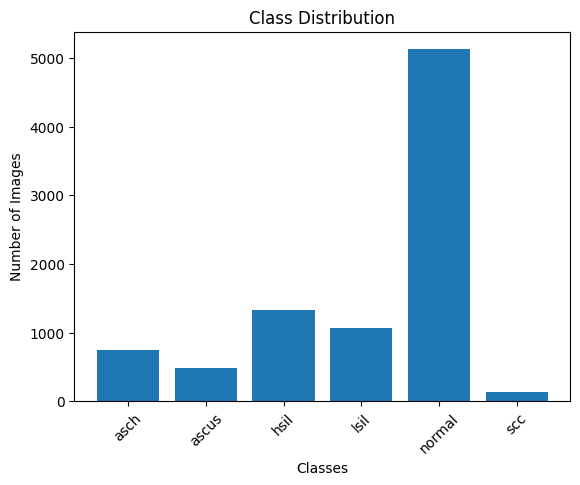

In [7]:
# Print data distribution
import numpy as np
import matplotlib.pyplot as plt

# Initialize a dictionary to store the class counts
class_counts = {class_name: 0 for class_name in dataset.class_names}

# Iterate through the dataset to count occurrences of each class
for images, labels in dataset:
    labels = np.argmax(labels.numpy(), axis=1)  # Convert one-hot encoded labels to class indices
    for label in labels:
        class_name = dataset.class_names[label]
        class_counts[class_name] += 1

# Print class counts
print("Class distribution in the training dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Plot a bar chart of the class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()


## Augmentation

In [8]:
import tensorflow as tf

# List of minority classes (asch, ascus, scc)
minority_classes = ['asch', 'ascus', 'scc']
minority_class_indices = [dataset.class_names.index(cls) for cls in minority_classes]

# Unbatch the dataset to process individual images
unbatched_dataset = dataset.unbatch()

# Function to check if the label belongs to one of the minority classes
def is_minority_class(image, label):
    # Check if the label belongs to the minority classes
    return tf.reduce_any(tf.math.equal(tf.argmax(label, axis=-1), minority_class_indices))

# Filter to keep only the minority classes
minority_dataset = unbatched_dataset.filter(is_minority_class)

# Define augmentation function for a single image
def augment_single_image(image, image_side_size):
    # Apply random rotations (90º, 180º, 270º)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Apply random horizontal and vertical flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Apply zoom by scaling and resizing (alternative to random_crop)
    scaling_factor = tf.random.uniform([], minval=0.8, maxval=1.2, dtype=tf.float32)
    new_size = tf.cast(scaling_factor * 100, tf.int32)

    # Resize the image by scaling factor and then resize back to original size
    image = tf.image.resize(image, [new_size, new_size])
    image = tf.image.resize_with_crop_or_pad(image, image_side_size, image_side_size)

    return image

# Apply augmentation to the minority class dataset
augmented_minority_dataset = minority_dataset.map(lambda image, label: (augment_single_image(image, image_side_size), label))

# Re-batch the dataset after augmentation
augmented_minority_dataset = augmented_minority_dataset.batch(32)

# Concatenate the original and augmented datasets
final_dataset = dataset.concatenate(augmented_minority_dataset)

# Prefetch and shuffle the final dataset
final_dataset = final_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Class distribution in the final dataset (after augmentation):
asch: 1494
ascus: 960
hsil: 1335
lsil: 1070
normal: 5127
scc: 258


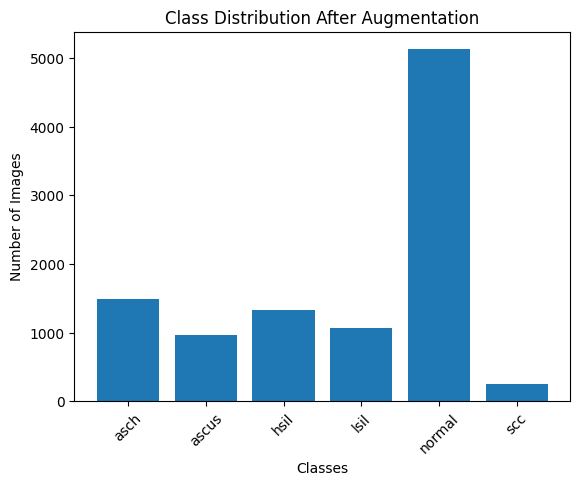

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize a dictionary to store the class counts
class_counts = {class_name: 0 for class_name in dataset.class_names}

# Iterate through the final_dataset to count occurrences of each class
for images, labels in final_dataset:
    labels = np.argmax(labels.numpy(), axis=1)  # Convert one-hot encoded labels to class indices
    for label in labels:
        class_name = dataset.class_names[label]
        class_counts[class_name] += 1

# Print class counts
print("Class distribution in the final dataset (after augmentation):")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Plot a bar chart of the class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution After Augmentation')
plt.xticks(rotation=45)
plt.show()


In [10]:
class_factor = {
    'asch': (class_counts['normal']/class_counts['asch']) - 1,
    'ascus': (class_counts['normal']/class_counts['ascus']) - 1,
    'hsil': (class_counts['normal']/class_counts['hsil']) - 1,
    'lsil': (class_counts['normal']/class_counts['lsil']) - 1,
    'scc': (class_counts['normal']/class_counts['scc']) - 1
}

class_factor

{'asch': 2.431726907630522,
 'ascus': 4.340625,
 'hsil': 2.8404494382022474,
 'lsil': 3.791588785046729,
 'scc': 18.872093023255815}

In [11]:
import tensorflow as tf
import numpy as np

# List of minority classes (asch, ascus, scc)
minority_classes = ['asch', 'ascus', 'hsil', 'lsil', 'scc']
minority_class_indices = [dataset.class_names.index(cls) for cls in minority_classes]

# Unbatch the dataset to process individual images
unbatched_dataset = dataset.unbatch()

# Function to check if the label belongs to one of the minority classes
def is_minority_class(image, label):
    # Check if the label belongs to the minority classes
    return tf.reduce_any(tf.math.equal(tf.argmax(label, axis=-1), minority_class_indices))

# Filter to keep only the minority classes
scc_dataset = unbatched_dataset.filter(is_minority_class)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,       # Rotate the image by up to 20 degrees
    width_shift_range=0.2,   # Shift the image horizontally by up to 20%
    height_shift_range=0.2,  # Shift the image vertically by up to 20%
    shear_range=0.2,         # Shear the image by 20%
    zoom_range=0.2,          # Zoom in/out by 20%
    horizontal_flip=True,    # Randomly flip images horizontally
    vertical_flip=True       # Randomly flip images vertically
)

# Generate augmented images for SCC class
# Set a batch size (e.g., 32) and number of augmentations (e.g., augment each image 5 times)
augmented_scc_images = []
augmented_scc_labels = []

for image, label in scc_dataset:
    image = np.expand_dims(image, axis=0)  # Expand dimension for the generator
    i = 0

    class_name = dataset.class_names[label.numpy().argmax()]
    max_aug = class_factor[class_name]

    for batch in datagen.flow(image, batch_size=1):
        augmented_scc_images.append(batch[0])  # Add the augmented image
        augmented_scc_labels.append(dataset.class_names.index(class_name))  # Add the corresponding SCC label
        i += 1
        if i >= max_aug:
            break


# Convert the augmented data to TensorFlow tensors
augmented_scc_images = tf.convert_to_tensor(augmented_scc_images)
augmented_scc_labels = tf.convert_to_tensor(augmented_scc_labels)

# Convert augmented labels to one-hot encoded format
augmented_scc_labels_one_hot = tf.one_hot(augmented_scc_labels, 6)

# Create a dataset from the augmented data
augmented_scc_dataset = tf.data.Dataset.from_tensor_slices((augmented_scc_images, augmented_scc_labels_one_hot))
augmented_scc_dataset = augmented_scc_dataset.batch(batch_size)
# Combine the original dataset with the augmented SCC data
final_dataset = final_dataset.concatenate(augmented_scc_dataset)

# Prefetch and shuffle the final dataset
final_dataset = final_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Class distribution in the final dataset (after augmentation):
asch: 3735
ascus: 3360
hsil: 5340
lsil: 5350
normal: 5127
scc: 2709


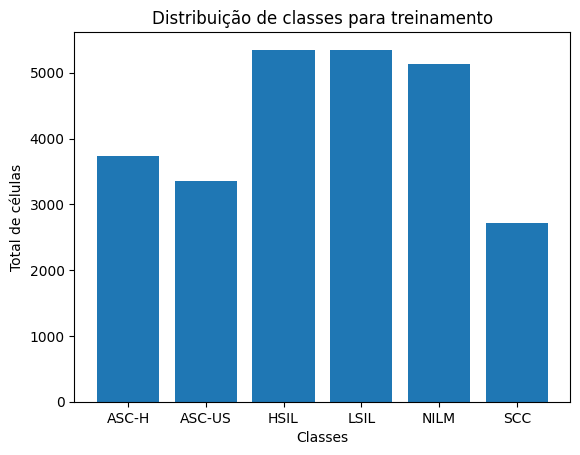

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize a dictionary to store the class counts
class_counts = {class_name: 0 for class_name in dataset.class_names}

# Iterate through the final_dataset to count occurrences of each class
for images, labels in final_dataset:
    labels = np.argmax(labels.numpy(), axis=1)  # Convert one-hot encoded labels to class indices
    for label in labels:
        class_name = dataset.class_names[label]
        class_counts[class_name] += 1

# Print class counts
print("Class distribution in the final dataset (after augmentation):")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")
labels = ['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'NILM', 'SCC']



# Plot a bar chart of the class distribution
plt.bar(labels, class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Total de células')
plt.title('Distribuição de classes para treinamento')
plt.show()

## Class weights

In [13]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Create a list of class labels (these correspond to indices used in training)
class_labels = list(class_counts.keys())
class_indices = np.array([class_labels.index(cls) for cls in class_labels])
class_samples = np.array([class_counts[cls] for cls in class_labels])

# Calculate the class weights
class_weights = compute_class_weight(
    'balanced',
    classes=class_indices,
    y=np.repeat(class_indices, class_samples)
)

# Convert the class weights into a dictionary to pass into the model during training
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Print the class weights
print("Class weights: ", class_weight_dict)


Class weights:  {0: 1.1432842481035252, 1: 1.2708829365079366, 2: 0.7996566791510612, 3: 0.7981619937694704, 4: 0.8328782263832001, 5: 1.5762889134982159}


# Training and comparisons

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0, InceptionV3, MobileNetV3Small, EfficientNetV2B0
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
import matplotlib.pyplot as plt

In [15]:
# List of models to compare
model_list = {
    # 'VGG16': VGG16,
    # 'ResNet50': ResNet50,
    # 'EfficientNetB0': EfficientNetB0,
    'InceptionV3': InceptionV3,
    # 'MobileNetV3Small': MobileNetV3Small,
    # 'EfficientNetV2B0': EfficientNetV2B0
}

# Function to build and compile a model
def build_model(model_name, input_shape, num_classes):
    base_model = model_list[model_name](weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model layers

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    #InceptionV3 test
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    # model.compile(optimizer=Adam(),
    #               loss='categorical_crossentropy',
    #               metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    return model



In [16]:
# Train each model and store the results
model_results = {}

# Train each model
for model_name in model_list.keys():
    print(f"Training {model_name}...")

    # Build model
    model = build_model(model_name, input_shape=(image_side_size, image_side_size, 3), num_classes=len(dataset.class_names))

    # Callbacks for early stopping and saving the best model
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(f'{model_name}_75x75_best_model.keras', monitor='val_loss', save_best_only=True)
    ]

    # Train the model
    history = model.fit(
        final_dataset,
        epochs=100,  # Adjust the number of epochs if necessary
        validation_data=val_dataset,
        class_weight=class_weight_dict,  # Apply class weights
        callbacks=callbacks
    )

    # Evaluate the model
    print(f"Evaluating {model_name} on validation set:")
    val_loss, val_acc, val_recall, val_precision = model.evaluate(val_dataset)

    # Example: Generate confusion matrix and ROC curve for one model (e.g., VGG16)
    print(f'Genearting predictions for {model_name} on validation set:')
    y_true = []  # Store true labels
    y_pred = []  # Store predicted labels
    y_pred_prob = []  # Store predicted probabilities for ROC curve

    # Get predictions from the trained model
    for images, labels in val_dataset:
        preds = model.predict(images)
        y_true.append(np.argmax(labels, axis=1))
        y_pred.append(np.argmax(preds, axis=1))
        y_pred_prob.append(preds)

    # Convert lists to numpy arrays
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    y_pred_prob = np.concatenate(y_pred_prob)

    # Save metrics for comparison
    model_results[model_name] = {
        'history': history,
        'model': model,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'val_recall': val_recall,
        'val_precision': val_precision,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob
    }

Training InceptionV3...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/100
    232/Unknown 58s 169ms/step - accuracy: 0.2080 - loss: 12.3541 - precision: 0.2080 - recall: 0.2079

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


234/234 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.2083 - loss: 12.3502 - precision: 0.2083 - recall: 0.2081 - val_accuracy: 0.3269 - val_loss: 10.3067 - val_precision: 0.3270 - val_recall: 0.3269
Epoch 2/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.2693 - loss: 11.4317 - precision: 0.2694 - recall: 0.2692 - val_accuracy: 0.5178 - val_loss: 7.2214 - val_precision: 0.5180 - val_recall: 0.5178
Epoch 3/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.3192 - loss: 10.7181 - precision: 0.3194 - recall: 0.3191 - val_accuracy: 0.4471 - val_loss: 8.3532 - val_precision: 0.4475 - val_recall: 0.4471
Epoch 4/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.3277 - loss: 10.2361 - precision: 0.3278 - recall: 0.3276 - val_accuracy: 0.4678 - val_loss: 8.0141 - val_precision: 0.4682 - val_recall: 0.4674
Epoch 5/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.3412 - loss: 9.8090 - precision: 0.3413 - recall: 0.3410 - val_accuracy: 0.4304 - val_loss:

## ROC Curve

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Function to plot the ROC curve
def plot_roc_curve(y_true, y_pred_prob, class_names, model_name):
    # One-hot encode the true labels
    y_true_one_hot = label_binarize(y_true, classes=range(len(class_names)))

    classes_map = {
        'asch':'ASC-H',
        'ascus':'ASC-US',
        'hsil':'HSIL',
        'lsil':'LSIL',
        'normal':'NILM',
        'scc':'SCC',
    }

    fpr = {}
    tpr = {}
    roc_auc = {}

    plt.figure()
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{classes_map[class_names[i]]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de falsos positivos')
    plt.ylabel('Taxa de verdadeiros positivos')
    plt.title(f'Curva ROC ({model_name})')
    plt.legend(loc='lower right')
    plt.show()

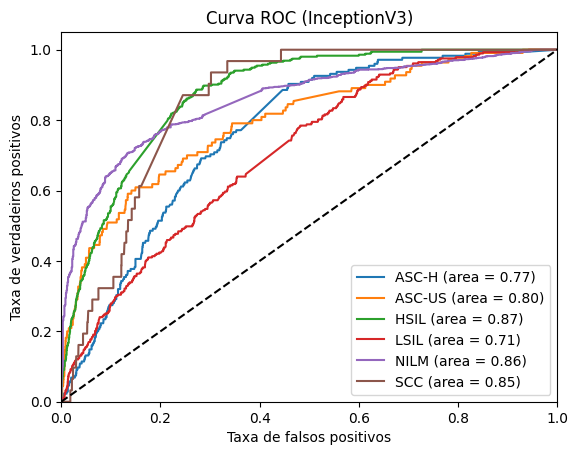

In [18]:
# # Example: Generate confusion matrix and ROC curve for one model (e.g., VGG16)
# y_true = []  # Store true labels
# y_pred = []  # Store predicted labels
# y_pred_prob = []  # Store predicted probabilities for ROC curve

# # Get predictions from the trained model
# for images, labels in val_dataset:
#     preds = model.predict(images)
#     y_true.append(np.argmax(labels, axis=1))
#     y_pred.append(np.argmax(preds, axis=1))
#     y_pred_prob.append(preds)

# # Convert lists to numpy arrays
# y_true = np.concatenate(y_true)
# y_pred = np.concatenate(y_pred)
# y_pred_prob = np.concatenate(y_pred_prob)

# Plot the ROC curve
for model_name, results in model_results.items():
  y_true = results['y_true']
  y_pred_prob = results['y_pred_prob']
  plot_roc_curve(y_true, y_pred_prob, dataset.class_names, model_name)

# Metrics extraction

## Confusion Matrix

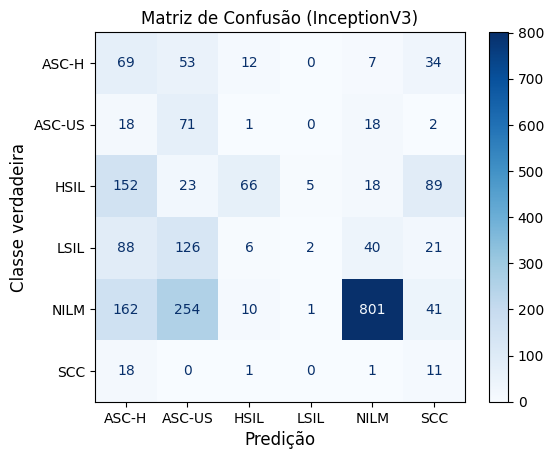

In [19]:
# Matriz de confusão

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'NILM', 'SCC'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Matriz de Confusão ({model_name})')
    plt.xlabel('Predição', fontsize=12)  # Customize x-axis label
    plt.ylabel('Classe verdadeira', fontsize=12)       # Customize y-axis label
    plt.show()

# Example: Generate confusion matrix for one model
# y_pred = []  # Store predicted labels

# # Get predictions from the trained model
# for images, labels in val_dataset:
#     preds = model.predict(images)
#     y_pred.append(np.argmax(preds, axis=1))

# # Convert lists to numpy arrays
# y_pred = np.concatenate(y_pred)

# model_list = {
#     'VGG16': VGG16,
#     'ResNet50': ResNet50,
#     'EfficientNetB0': EfficientNetB0,
#     'InceptionV3': InceptionV3,
#     'MobileNetV3Small': MobileNetV3Small,
#     'EfficientNetV2B0': EfficientNetV2B0
# }

# Plot the confusion matrix
for model_name, results in model_results.items():
  y_true = results['y_true']
  y_pred = results['y_pred']
  plot_confusion_matrix(y_true, y_pred, class_names=dataset.class_names, model_name=model_name)

## Accuracy and loss curves

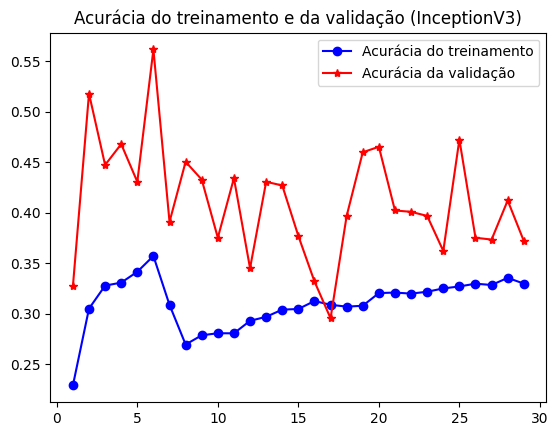

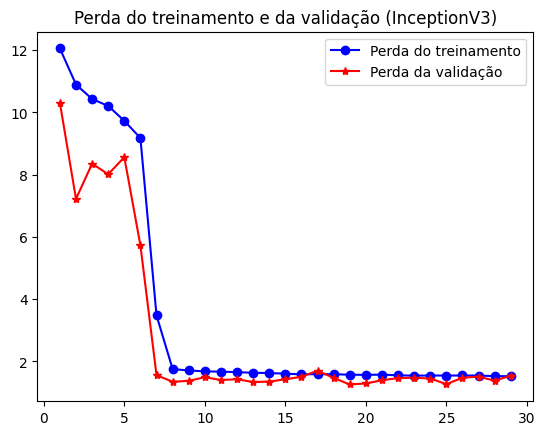

In [20]:
# Curva de perda e acurácia

# Function to plot loss and accuracy curves
def plot_loss_accuracy(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, acc, 'bo-', label='Acurácia do treinamento')
    plt.plot(epochs, val_acc, 'r*-', label='Acurácia da validação')
    plt.title(f'Acurácia do treinamento e da validação ({model_name})')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure()
    plt.plot(epochs, loss, 'bo-', label='Perda do treinamento')
    plt.plot(epochs, val_loss, 'r*-', label='Perda da validação')
    plt.title(f'Perda do treinamento e da validação ({model_name})')
    plt.legend()
    plt.show()

# model_list = {
#     'VGG16': VGG16,
#     'ResNet50': ResNet50,
#     'EfficientNetB0': EfficientNetB0,
#     'InceptionV3': InceptionV3,
#     'MobileNetV3Small': MobileNetV3Small,
#     'EfficientNetV2B0': EfficientNetV2B0
# }

# Example: Plot loss and accuracy for one model

for model_name, results in model_results.items():
  history = results['history']
  plot_loss_accuracy(history, model_name)


## Additional metrics

In [21]:
for model_name, results in model_results.items():
  y_true = results['y_true']
  y_pred = results['y_pred']

  # Calculate precision, recall, F1 score
  print(f"Classification Report for {model_name}:")
  print(classification_report(y_true, y_pred, target_names=dataset.class_names))

  # Calculate F1 Score
  f1 = f1_score(y_true, y_pred, average='weighted')  # Weighted F1 for multiclass
  print(f"Weighted F1 Score for {model_name}: {f1:.4f}")

Classification Report for InceptionV3:
              precision    recall  f1-score   support

        asch       0.14      0.39      0.20       175
       ascus       0.13      0.65      0.22       110
        hsil       0.69      0.19      0.29       353
        lsil       0.25      0.01      0.01       283
      normal       0.91      0.63      0.74      1269
         scc       0.06      0.35      0.10        31

    accuracy                           0.46      2221
   macro avg       0.36      0.37      0.26      2221
weighted avg       0.68      0.46      0.50      2221

Weighted F1 Score for InceptionV3: 0.5017
